In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

np.random.seed(42)

tf.random.set_seed(42)

data = pd.read_csv('diabetes.csv')

print(data.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [2]:
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

imputer = SimpleImputer(missing_values=0, strategy="mean")

for col in cols_with_zeros:
    data[col] = imputer.fit_transform(data[col].values.reshape(-1, 1))

In [3]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

In [4]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


# Test 1: One layer with 16 neurons with or w/o adaptive learning rate (Adam optimizer)

2023-09-29 22:23:18.426167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:23:18.790580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:23:25.363954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:23:25.695569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


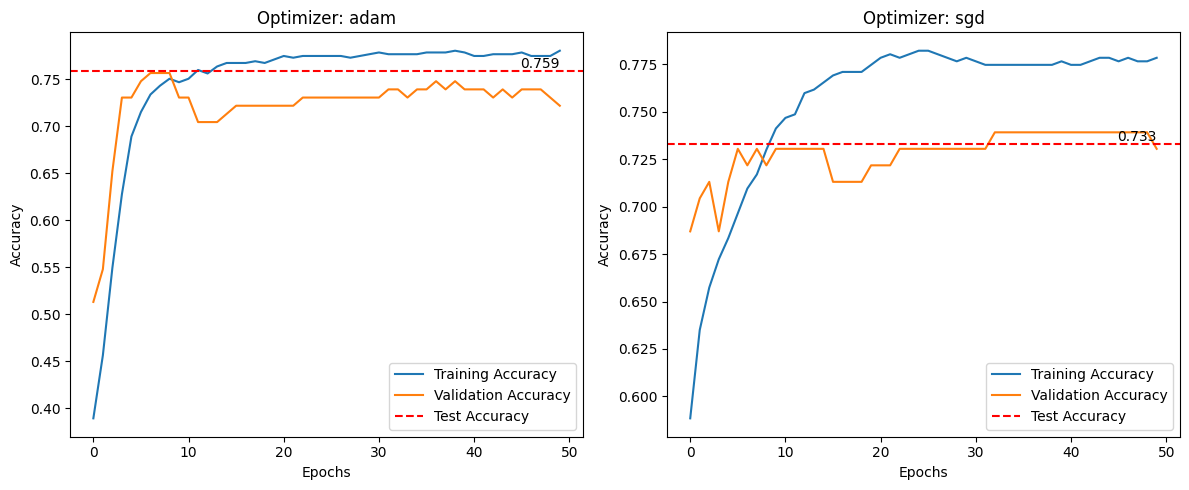

In [6]:
def create_model(optimizer='adam'):
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

optimizers = ["adam", "sgd"]

histories = {}
test_accuracies = {}

plt.figure(figsize=(12, 5))

for index, optimizer in enumerate(optimizers):
    model = create_model(optimizer)
    histories[optimizer] = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)
    test_accuracies[optimizer] = model.evaluate(X_test, y_test, verbose=0)[1]

    plt.subplot(1, 2, index+1)
    plt.plot(histories[optimizer].history['accuracy'], label='Training Accuracy')
    plt.plot(histories[optimizer].history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(test_accuracies[optimizer], color='red', label='Test Accuracy', linestyle='dashed')
    plt.text(len(histories[optimizer].history['accuracy'])-1, test_accuracies[optimizer], f'{test_accuracies[optimizer]:.3f}', verticalalignment='bottom', horizontalalignment='right')
    plt.title(f"Optimizer: {optimizer}")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


# 2. single layer with 16 neurons w or w/ l2

2023-09-29 22:24:56.188693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:24:56.592088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:25:03.305485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:25:03.727365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


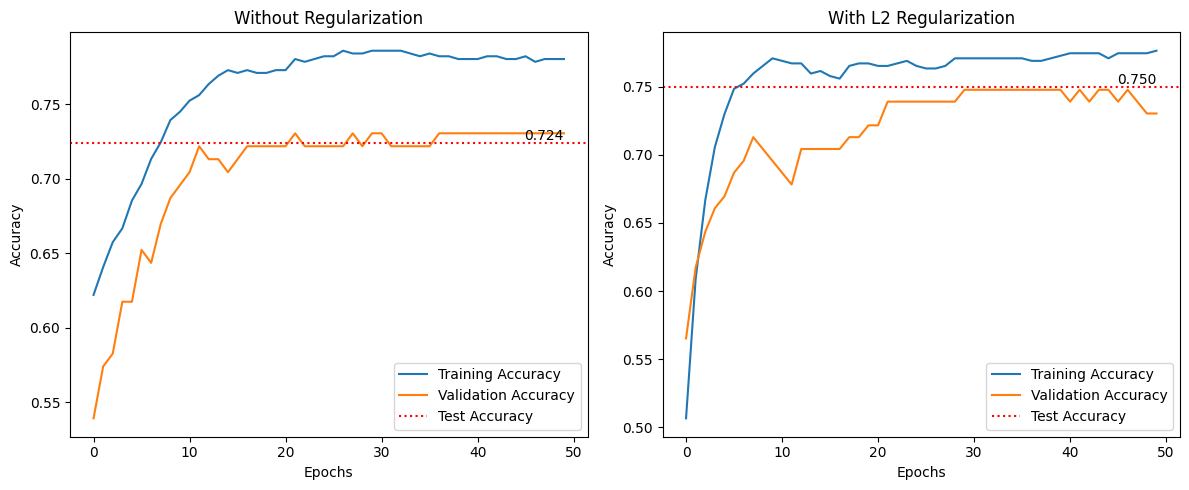

In [7]:
def create_model(regularization=None):
    if regularization is None:
        regularizer = None
    else:
        regularizer = tf.keras.regularizers.l2(regularization)

    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizer),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

models = {
    "Without Regularization": create_model(),
    "With L2 Regularization": create_model(regularization=0.01)
}

histories = {}
test_accuracies = {}

plt.figure(figsize=(12,5))

for index, (name, model) in enumerate(models.items()):
    histories[name] = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)
    test_accuracies[name] = model.evaluate(X_test, y_test, verbose=0)[1]
    
    plt.subplot(1, 2, index+1)
    plt.plot(histories[name].history['accuracy'], label='Training Accuracy')
    plt.plot(histories[name].history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(test_accuracies[name], color='red', linestyle='dotted', label='Test Accuracy')
    plt.text(len(histories[name].history['accuracy'])-1, test_accuracies[name], f'{test_accuracies[name]:.3f}', verticalalignment='bottom', horizontalalignment='right')
    plt.title(name)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

# 3. single layer with 16 neurons w or w/ dropout

2023-09-29 22:26:47.051124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:26:47.541952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:26:57.209774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:26:57.730560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


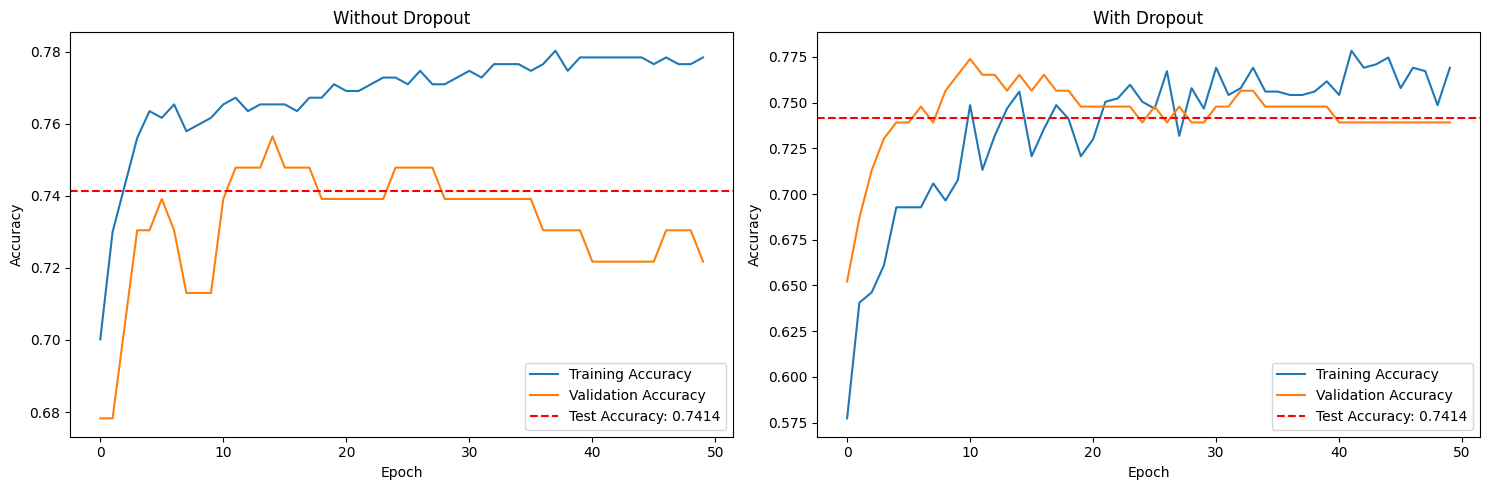

In [8]:
def create_model(use_dropout=False):
    if use_dropout:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    else:
        model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

settings = ["Without Dropout", "With Dropout"]

histories = {}
test_accuracies = {}

for setting in settings:
    model = create_model("With Dropout" in setting)
    histories[setting] = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)
    _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    test_accuracies[setting] = test_accuracy

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, setting in enumerate(settings):
    axes[i].plot(histories[setting].history['accuracy'], label='Training Accuracy')
    axes[i].plot(histories[setting].history['val_accuracy'], label='Validation Accuracy')
    axes[i].axhline(y=test_accuracies[setting], color='r', linestyle='--', label=f"Test Accuracy: {test_accuracies[setting]:.4f}")
    axes[i].set_title(setting)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

# 4. single layer with 16 neurons w or w/ batch_norm

2023-09-29 22:31:02.582236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:31:03.343459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:31:14.457062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:31:15.526268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


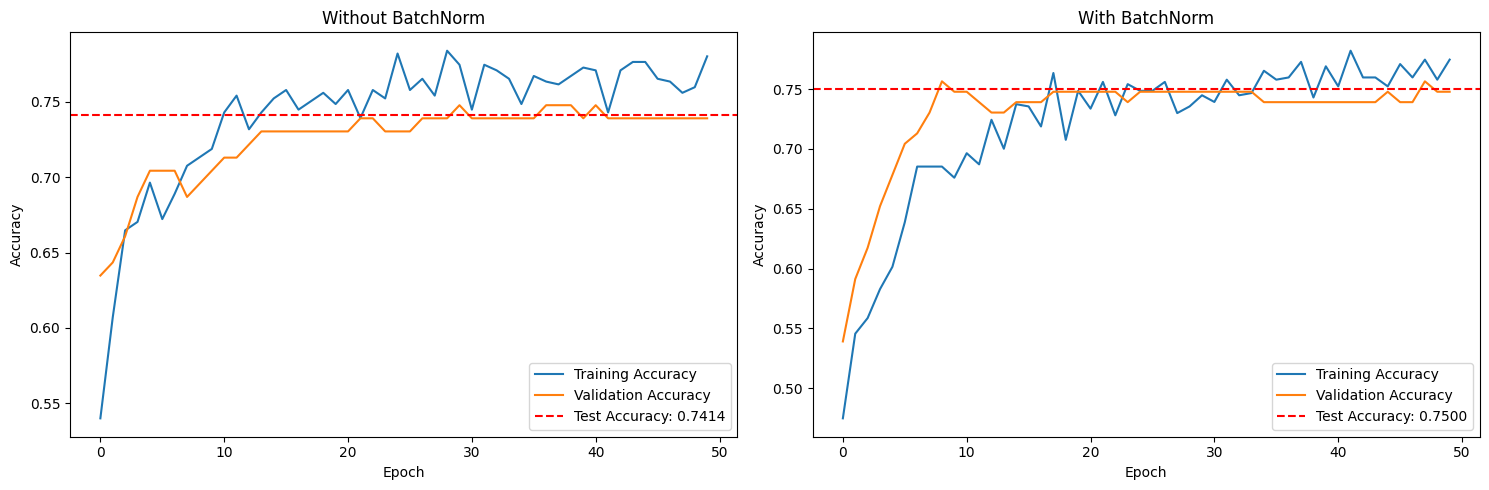

In [15]:
def create_model(use_batchnorm=False):
    layers = [
        tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))
    ]
    
    if use_batchnorm:
        layers.append(tf.keras.layers.BatchNormalization())
    
    layers.append(tf.keras.layers.Dropout(0.5))
    layers.append(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model = tf.keras.models.Sequential(layers)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

settings_bn = ["Without BatchNorm", "With BatchNorm"]

histories_bn = {}
test_accuracies_bn = {}

for setting in settings_bn:
    model = create_model("With BatchNorm" in setting)
    histories_bn[setting] = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)
    _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    test_accuracies_bn[setting] = test_accuracy

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, setting in enumerate(settings_bn):
    axes[i].plot(histories_bn[setting].history['accuracy'], label='Training Accuracy')
    axes[i].plot(histories_bn[setting].history['val_accuracy'], label='Validation Accuracy')
    axes[i].axhline(y=test_accuracies_bn[setting], color='r', linestyle='--', label=f"Test Accuracy: {test_accuracies_bn[setting]:.4f}")
    axes[i].set_title(setting)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()



# 5. single layer with 8, 32, 64, 128 neurons

2023-09-29 22:32:01.037725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:32:02.232446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:32:17.378043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:32:18.729621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:32:32.651071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:32:33.834856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:32:47.082459: I tensorflow/core/grappler/optimizers/cust

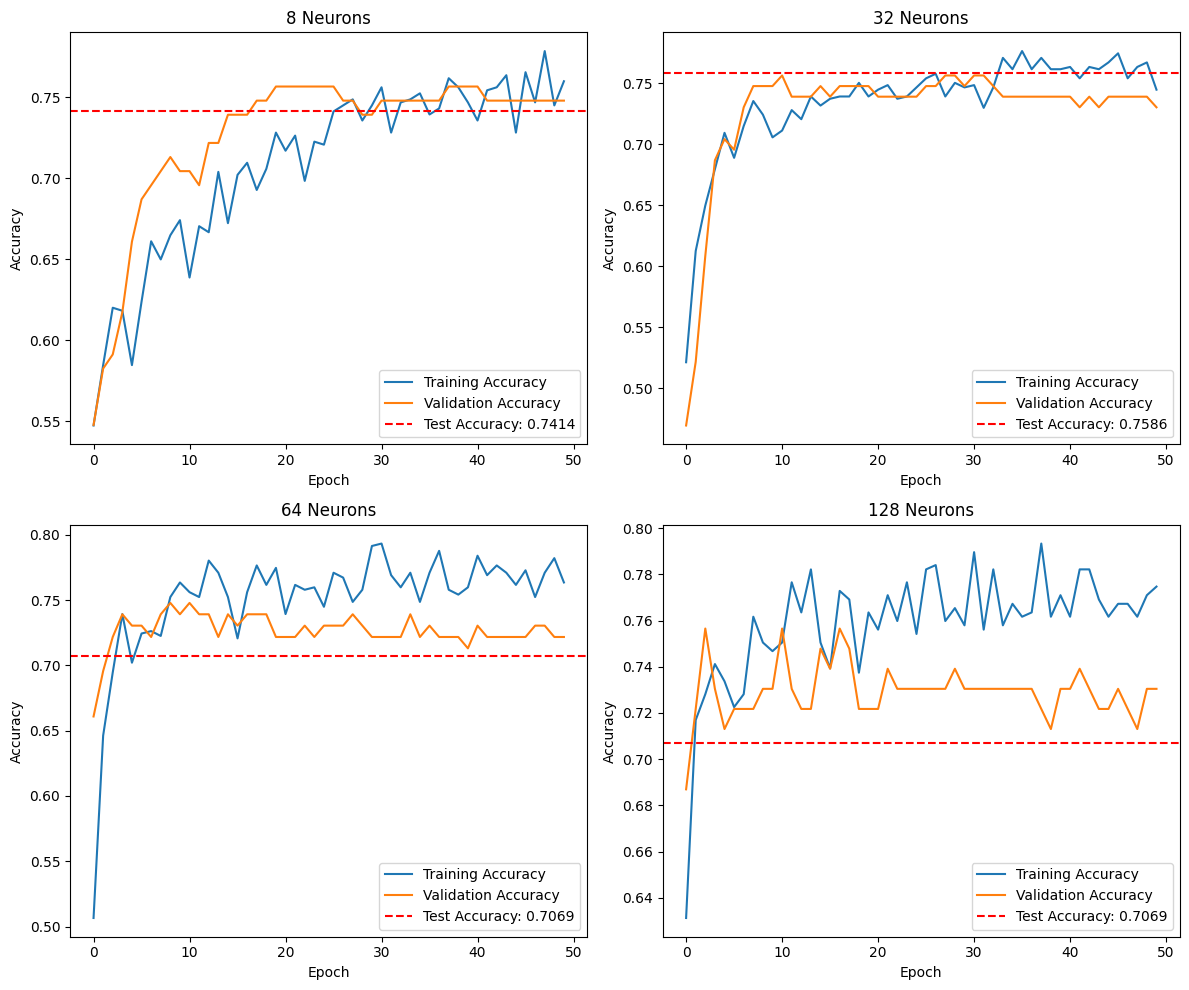

In [17]:
def create_neuron_model(n_neurons):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(n_neurons, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

neuron_settings = [8, 32, 64, 128]

histories_neurons = {}
test_accuracies_neurons = {}

for neurons in neuron_settings:
    model = create_neuron_model(neurons)
    histories_neurons[neurons] = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=0)
    _, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    test_accuracies_neurons[neurons] = test_accuracy

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, neurons in enumerate(neuron_settings):
    row = i // 2
    col = i % 2
    axes[row][col].plot(histories_neurons[neurons].history['accuracy'], label='Training Accuracy')
    axes[row][col].plot(histories_neurons[neurons].history['val_accuracy'], label='Validation Accuracy')
    axes[row][col].axhline(y=test_accuracies_neurons[neurons], color='r', linestyle='--', label=f"Test Accuracy: {test_accuracies_neurons[neurons]:.4f}")
    axes[row][col].set_title(f"{neurons} Neurons")
    axes[row][col].set_xlabel('Epoch')
    axes[row][col].set_ylabel('Accuracy')
    axes[row][col].legend()

plt.tight_layout()
plt.show()

# 6. 1, 2, 3, 4 layer with 16 neurons

2023-09-29 22:47:49.426550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:47:52.573017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:48:14.066134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:48:18.487075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:48:54.705923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:49:01.042813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:49:53.904065: I tensorflow/core/grappler/optimizers/cust

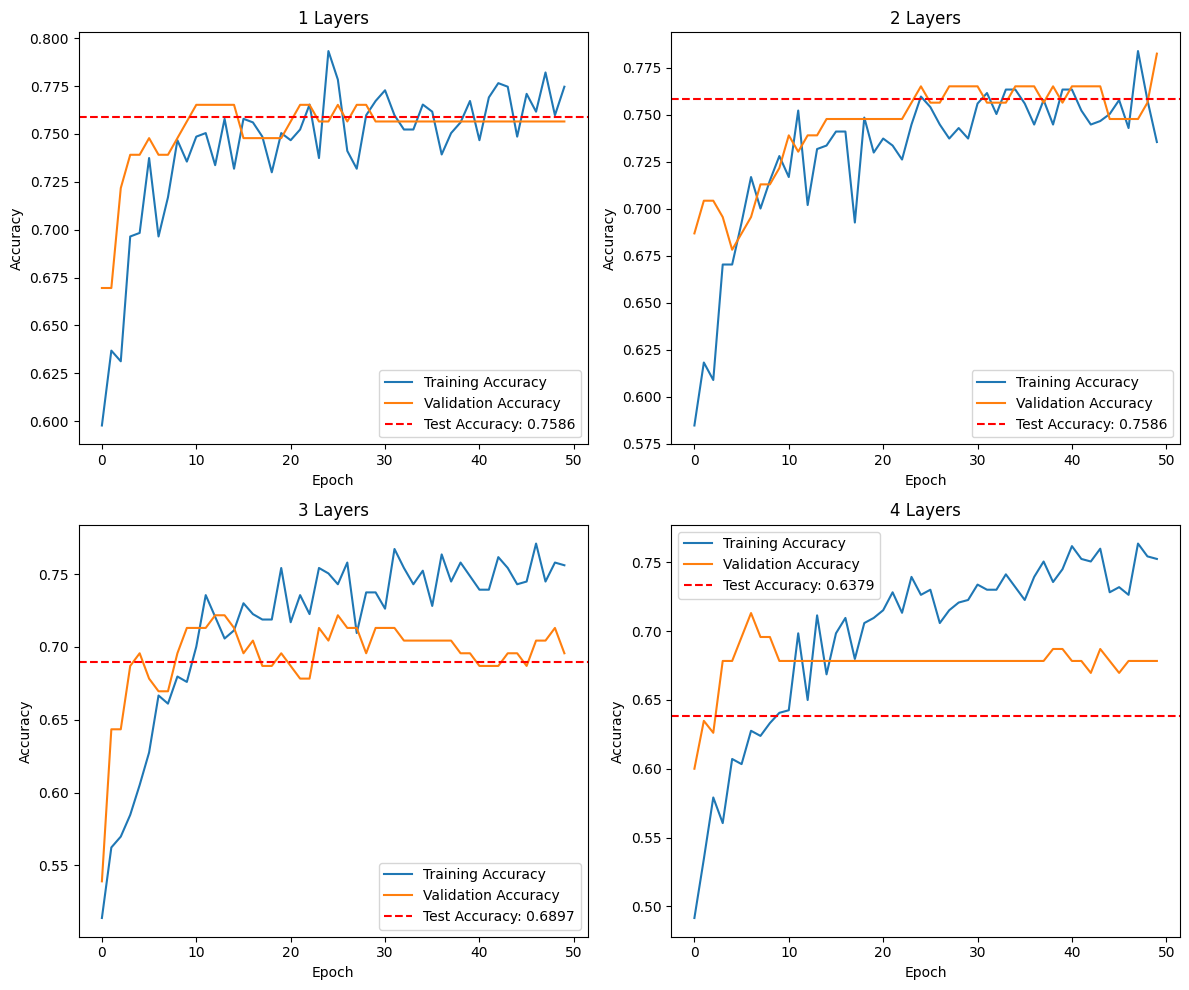

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

layer_settings = [1, 2, 3, 4]
histories_layers = {}
test_accuracies_layers = {}

for layers in layer_settings:
    model = Sequential()
    
    for i in range(layers):
        if i == 0:
            model.add(Dense(16, activation='relu', kernel_regularizer=l2(), input_shape=(X_train.shape[1],)))
        else:
            model.add(Dense(16, activation='relu', kernel_regularizer=l2()))
        model.add(Dropout(0.5))
        model.add(BatchNormalization())
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    histories_layers[layers] = history
    
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    test_accuracies_layers[layers] = test_acc

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, layers in enumerate(layer_settings):
    row = i // 2
    col = i % 2
    axes[row][col].plot(histories_layers[layers].history['accuracy'], label='Training Accuracy')
    axes[row][col].plot(histories_layers[layers].history['val_accuracy'], label='Validation Accuracy')
    axes[row][col].axhline(y=test_accuracies_layers[layers], color='r', linestyle='--', label=f"Test Accuracy: {test_accuracies_layers[layers]:.4f}")
    axes[row][col].set_title(f"{layers} Layers")
    axes[row][col].set_xlabel('Epoch')
    axes[row][col].set_ylabel('Accuracy')
    axes[row][col].legend()

plt.tight_layout()
plt.show()

# 7. 4 2-layers models

2023-09-29 22:55:15.645948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:55:20.430648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:55:57.514247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:56:02.435235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:56:38.213469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:56:43.069015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-29 22:57:17.769072: I tensorflow/core/grappler/optimizers/cust

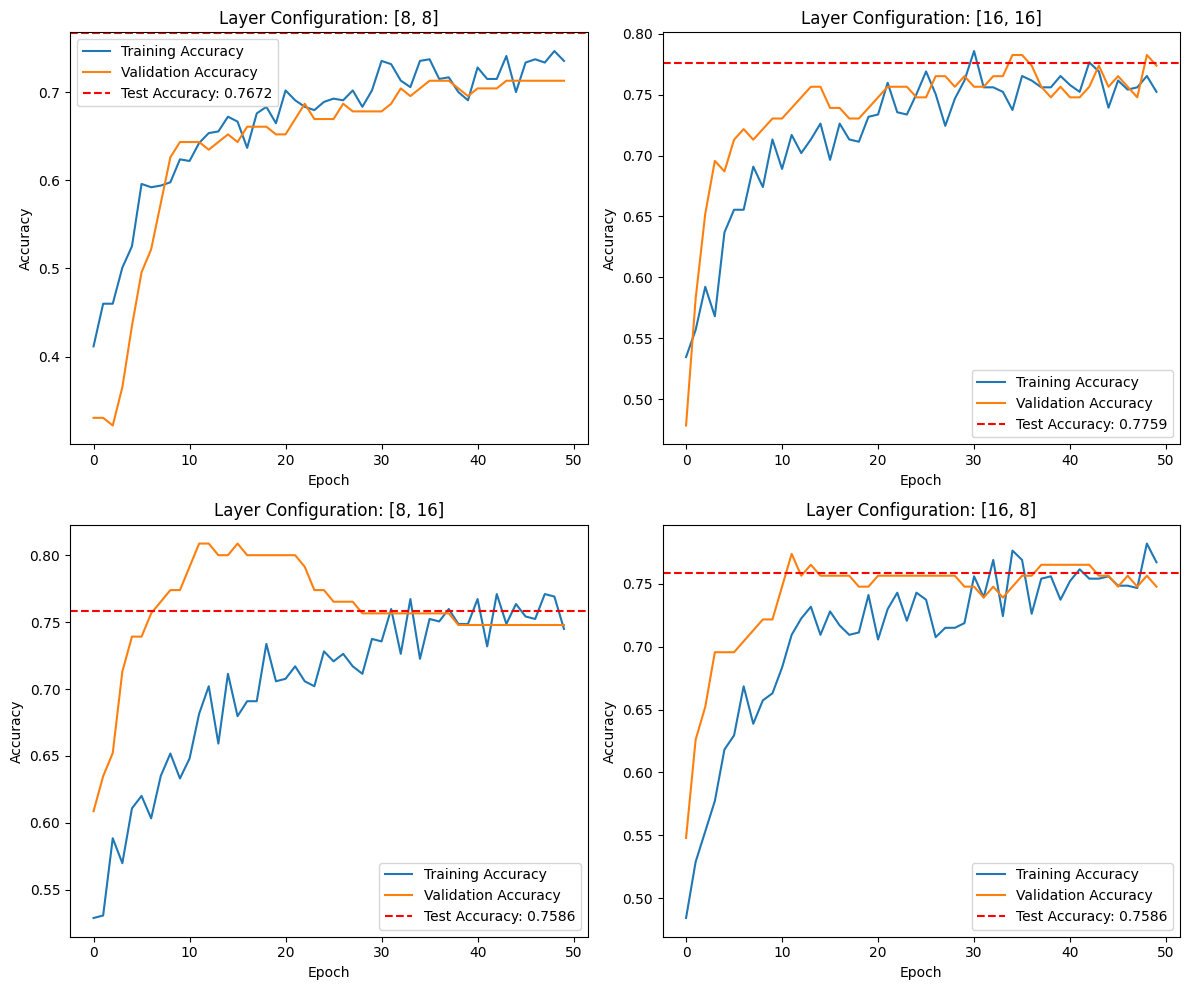

In [28]:
configurations = [[8, 8], [16, 16], [8, 16], [16, 8]]
histories_config = {}
test_accuracies_config = {}

for config in configurations:
    model = Sequential()
    
    model.add(Dense(config[0], activation='relu', kernel_regularizer=l2(), input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Dense(config[1], activation='relu', kernel_regularizer=l2()))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)
    histories_config[str(config)] = history
    
    _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    test_accuracies_config[str(config)] = test_acc

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, config in enumerate(configurations):
    row = i // 2
    col = i % 2
    axes[row][col].plot(histories_config[str(config)].history['accuracy'], label='Training Accuracy')
    axes[row][col].plot(histories_config[str(config)].history['val_accuracy'], label='Validation Accuracy')
    axes[row][col].axhline(y=test_accuracies_config[str(config)], color='r', linestyle='--', label=f"Test Accuracy: {test_accuracies_config[str(config)]:.4f}")
    axes[row][col].set_title(f"Layer Configuration: {config}")
    axes[row][col].set_xlabel('Epoch')
    axes[row][col].set_ylabel('Accuracy')
    axes[row][col].legend()

plt.tight_layout()
plt.show()
